# ClimateNet AR/TC Analysis: Global Frequency Maps

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '8GiB' # PBSCluster specification
nmem2 = '8GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

In [3]:
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/GPU/proxy/{port}/status'}) # need to include name of server if named!

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:34816,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Analysis notes
- replace `.where` with `.clip` if possible for speed

## Set ClimateNet filepath

In [4]:
#cesm_cnet_filepath = "/glade/campaign/cgd/amp/jet/ClimateNet/" # pretrained LBL model, 2000-2005
#cesm_cnet_filepath = "/glade/p/cgd/ccr/people/tking/cgnet_masks/" # retrained NCAR model, 2000-2015, after means/std bug fix

cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

In [25]:
#cesm_cnet_folders = ["output.cgnet.2000/", "output.cgnet.2001/", "output.cgnet.2002/", "output.cgnet.2003/", "output.cgnet.2004/", "output.cgnet.2005/"] # pretrained LBL model, 2000-2005
#cesm_cnet_folders = ["results.2000/", "results.2001/", "results.2002/", "results.2003/", "results.2004/", "results.2005/"] # retrained NCAR model, 2000-2006, before means/std bug fix
#cesm_cnet_folders = ["results.2000/"] # year 2000 only
#cesm_cnet_folders = ["tmq_psl_v850_u850/"] # retrained NCAR model, 2000-2015, after means/std bug fix
#cesm_cnet_folders = ["tmq_v850/actual_tmq_v850_masks/"] # after config file bug fix
#cesm_cnet_folders = ["tmq_only/actual_tmq_only_masks/"] # after config file bug fix

## CESM historical & RCP2.6 simulations

### Check for missing values in new RCP2.6 masks

In [7]:
%%time
rcp26_folder = "BRCP26C5CN/2006/masks_v2/"
cnet_files = "class_masks*.nc"
cnet_test = xr.open_mfdataset(cesm_cnet_filepath+rcp26_folder+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True)
cnet_test_mask = cnet_test.masks
cnet_test_mask_sum = cnet_test_mask.sum(dim=('lat','lon'))
cnet_test_mask_sum.where(cnet_test_mask_sum == 0).count().values

CPU times: user 2.04 s, sys: 288 ms, total: 2.33 s
Wall time: 14.5 s


array(0)

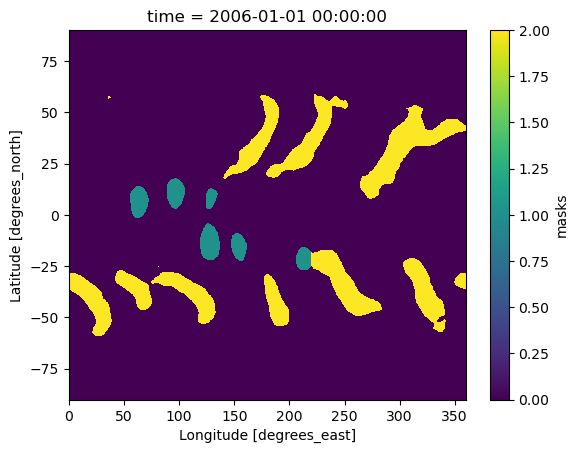

In [8]:
cnet_test_mask.isel(time=0).plot()

### Read in files

In [5]:
#cnet_files = "b.e13.B20TRC5CN.ne120_g16.003*.nc" # pretrained LBL model
#cnet_files = "class_masks*.nc" # retrained NCAR model
#cnet_files = "class_masks.200[0-5]*" # testing years 2000-2005

hist_yrs = [str(i) for i in range(2000,2006)]
#hist_folders = ["B20TRC5CN/"+y+"/masks/" for y in hist_yrs]
#hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std in config file
#hist_folders = ["B20TRC5CN/"+y+"/masks_TMQ_V850/" for y in hist_yrs] # pre-trained model using TMQ and V850 only
hist_folders = ["B20TRC5CN/"+y+"/masks_TMQ/" for y in hist_yrs] # pre-trained model using TMQ only

rcp26_yrs = [str(i) for i in range(2006,2016)]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks/" for y in rcp26_yrs]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_v2/" for y in rcp26_yrs] # updated data processing (3hrly PSL)
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # updated data processing (3hrly PSL), unweighted means/std in config file
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_TMQ_V850/" for y in rcp26_yrs] # pre-trained model using TMQ and V850 only
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_TMQ/" for y in rcp26_yrs] # pre-trained model using TMQ only

#cnet_folders = hist_folders+rcp26_folders
#cnet_folders

#cnet_files = "class_masks*.nc"

In [ ]:
# start with year 2000 only to solidfy workflow
#cnet_2000 = xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[0]+cnet_files, concat_dim='time', combine="nested", chunks={'time':360}, parallel=True) # aim for chunk size < 100mb
#cnet_2000

#### Slower way to read in

In [7]:
%%time
# read in all the masks
# adjust chunks for length of timeseries data
#cnet = [xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cesm_cnet_folders)]
cnet = [xr.open_mfdataset(cesm_cnet_filepath+cnet_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cnet_folders)]

# concat across time
cnet_concat = xr.concat(cnet,dim='time')

CPU times: user 1.32 s, sys: 329 ms, total: 1.65 s
Wall time: 30.1 s


In [91]:
cnet_concat

<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 46720)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [ ]:
#cnet_mask = cnet_concat.output_tag # pretrained LBL model
#cnet_mask = cnet_concat.__xarray_dataarray_variable__.rename("output_tag") # retrained NCAR model; rename data variable
cnet_mask = cnet_concat.masks
cnet_mask

#### Faster way to read in with one file per year

In [6]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)] + [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2001/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2002/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2003/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2004/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2005/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2006/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2007/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2008/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2009/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2010/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2011/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/

In [7]:
%%time
# read in all the masks feeding the list of paths - faster!
cnet = xr.open_mfdataset(paths, concat_dim='time', combine='nested', chunks={'time':50}, parallel=True)
cnet

CPU times: user 589 ms, sys: 277 ms, total: 866 ms
Wall time: 11 s


<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 46720)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [8]:
cnet_mask = cnet.masks
cnet_mask

<xarray.DataArray 'masks' (time: 46720, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(46720, 768, 1152), dtype=int64, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

#### Note the repeating index where the files meet
Can correct this with timeshift but should not matter for these frequency plots

In [27]:
cnet_mask.sel(time="2006-01-01 00:00:00")

<xarray.DataArray 'masks' (time: 2, lat: 768, lon: 1152)>
dask.array<getitem, shape=(2, 768, 1152), dtype=int64, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2006-01-01 00:00:00 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Static plot for visualization

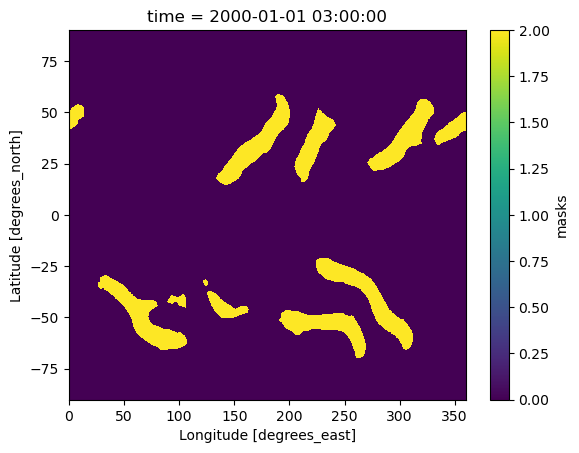

In [28]:
cnet_mask.isel(time=0).plot();

### Check for time indices with zero detection

In [11]:
cnet_mask_sum = cnet_mask.sum(dim=('lat','lon'))

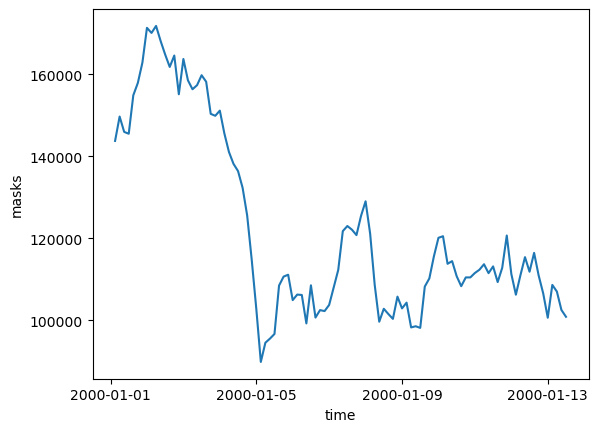

In [12]:
cnet_mask_sum.isel(time=slice(0,100)).plot()

In [13]:
cnet_mask_sum.where(cnet_mask_sum == 0).count().values

array(0)

Historical/RCP2.6 doesn't have any "empty" time indices

### A nicer plot

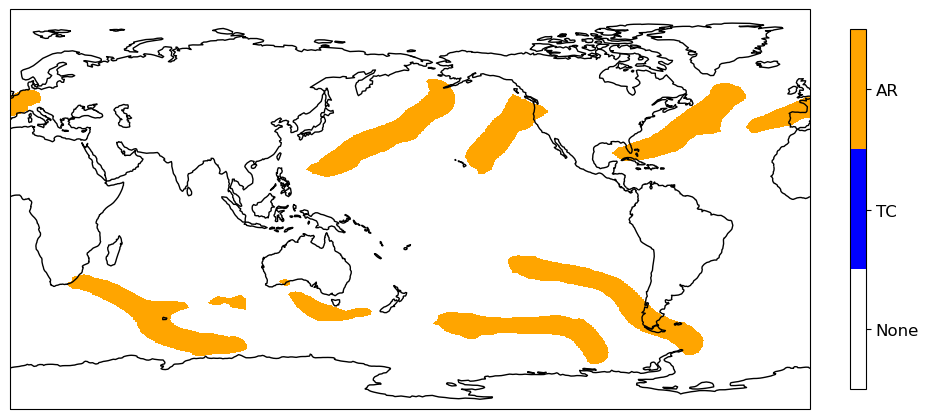

In [14]:
cmap_all = mcolors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
#norm = mcolors.BoundaryNorm(bounds, cmap_all.N)

fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # shift map center to highlight Pacific

lat = cnet_mask.lat
lon = cnet_mask.lon
#cf = ax.contourf(lon, lat, cnet_mask.isel(time=0), cmap=cmap_all, vmin=0, vmax=2.99, levels=bounds, transform=ccrs.PlateCarree())
pc = ax.pcolormesh(lon, lat, cnet_mask.isel(time=0), cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree()) # get rid of edge colors

ax.coastlines()

cbar_ax = fig.add_axes([1.05, 0.2, 0.02, 0.6])
norm = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

#plt.savefig('../figures/toSCP/CGnet_time=0_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-only_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0.png', bbox_inches='tight')

### Global AR frequency maps
See Lora et al. 2020 for comparison

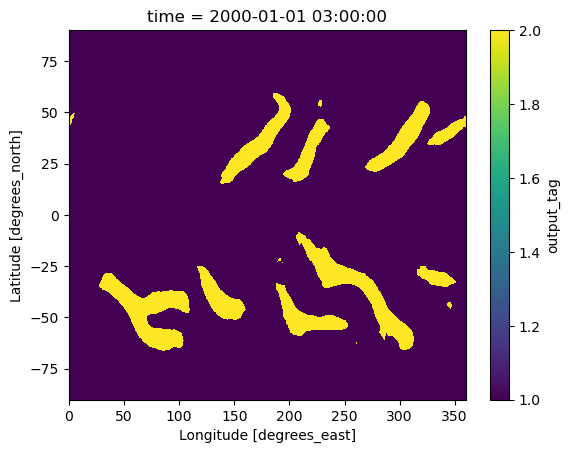

In [32]:
# TCs are still here, but now everything not AR has been set to 1
cnet_mask.clip(min=1).isel(time=0).plot();

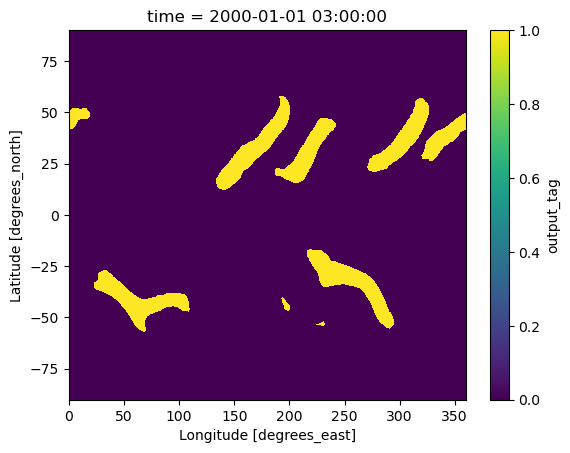

In [20]:
# method to select only ARs (value=2)
# clip is so much faster than where but it doesn't create a masked array
(cnet_mask.clip(min=1).isel(time=0)-1).plot(); # in absense of masked array, need to subtract 1 to get ARs = 1 and everything else = 0

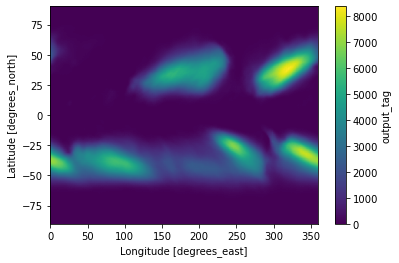

In [28]:
# sum at each gridpoint over time
(cnet_mask.clip(min=1)-1).sum(dim='time').plot()

In [29]:
len(cnet_mask.time)

17520

In [15]:
len(cnet_mask.time)

46720

In [30]:
npercentARs = 100*((cnet_mask.clip(min=1)-1).sum(dim='time'))/len(cnet_mask.time)
#npercentARs.plot(robust=True);

In [31]:
npercentARs = npercentARs.persist()

In [32]:
npercentARs.max().values

array(45.32320205)

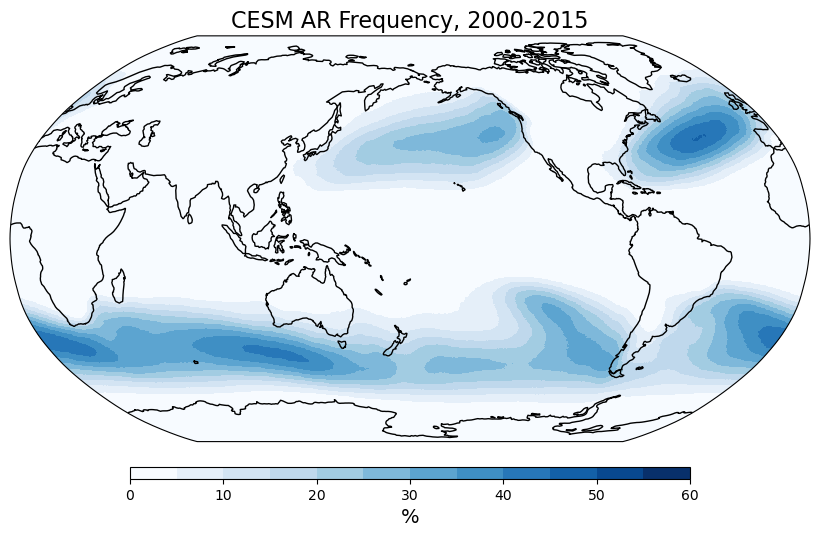

In [33]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)
vmax=60

# compare to Lora et al. 2020
#cmap=plt.cm.get_cmap('Blues', 10)
#vmax=25 # compare to Lora et al. 2020

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs.lat
lon = npercentARs.lon
pc = ax.pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('CESM AR Frequency, 2000-2005', fontsize=16); 
ax.set_title('CESM AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-only_configfix.png', bbox_inches='tight')

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_unwgt_Lora.png', bbox_inches='tight')

### Global TC frequency masks
Note: release the ``npercentARs`` variable from memory so the ``npercentTCs`` processing doesn't run out of memory (or increase the dask request?)

In [37]:
del npercentARs

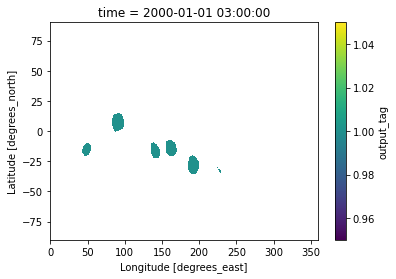

In [29]:
# can't figure out how to use .clip to select TCs
(cnet_mask.where(cnet_mask==1).isel(time=0)).plot() 

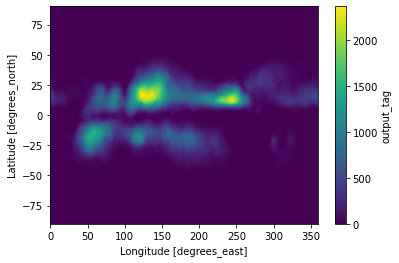

In [32]:
cnet_mask.where(cnet_mask==1).sum(dim='time').plot()

In [33]:
len(cnet_mask.time)

17520

In [9]:
# can't figure out how to use .clip to select TCs
npercentTCs = 100*(cnet_mask.where(cnet_mask==1).sum(dim='time'))/len(cnet_mask.time)

In [78]:
npercentTCs

<xarray.DataArray 'output_tag' (lat: 768, lon: 1152)>
dask.array<truediv, shape=(768, 1152), dtype=float64, chunksize=(768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7

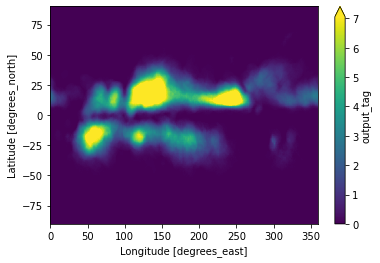

In [ ]:
npercentTCs.plot(robust=True);

In [10]:
npercentTCs = npercentTCs.persist()

In [11]:
npercentTCs.max().values

array(0.01284247)

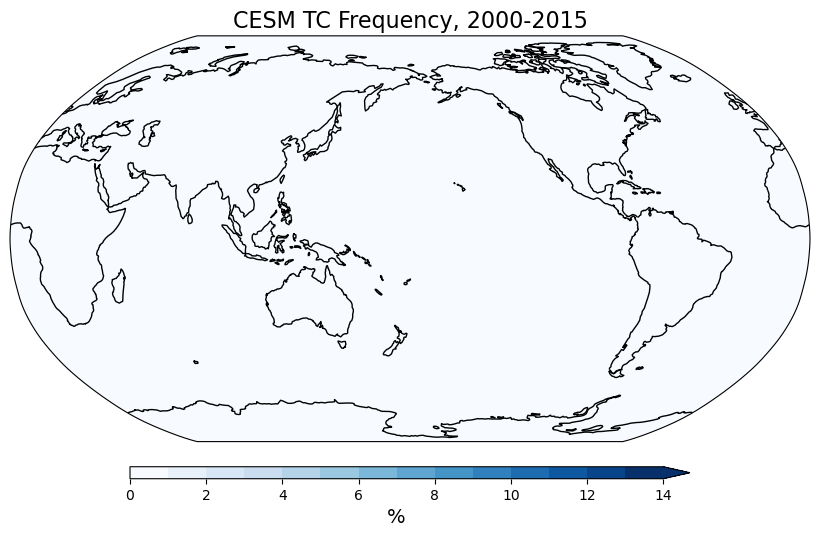

In [12]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 14)
vmax=14

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentTCs.lat
lon = npercentTCs.lon
pc = ax.pcolormesh(lon, lat, npercentTCs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('CESM TC Frequency, 2000-2005', fontsize=16); 
ax.set_title('CESM TC Frequency, 2000-2015', fontsize=16);

#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-only_configfix.png', bbox_inches='tight')

#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_unwgt.png', bbox_inches='tight')

## CESM RCP8.5 simulations

### Check for missing values in new RCP8.5 masks

In [7]:
%%time
rcp85_folder = "BRCP85C5CN/2086/masks_v2/"
cnet_files = "class_masks*.nc"
cnet_test = xr.open_mfdataset(cesm_cnet_filepath+rcp85_folder+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True)
cnet_test_mask = cnet_test.masks
cnet_test_mask_sum = cnet_test_mask.sum(dim=('lat','lon'))
cnet_test_mask_sum.where(cnet_test_mask_sum == 0).count().values

CPU times: user 507 ms, sys: 44.9 ms, total: 552 ms
Wall time: 10.7 s


array(0)

In [9]:
cnet_test_mask

<xarray.DataArray 'masks' (time: 2920, lat: 768, lon: 1152)>
dask.array<open_dataset-64bf225eb5f2cd292c7f7de8dfe35768masks, shape=(2920, 768, 1152), dtype=int64, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2086-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

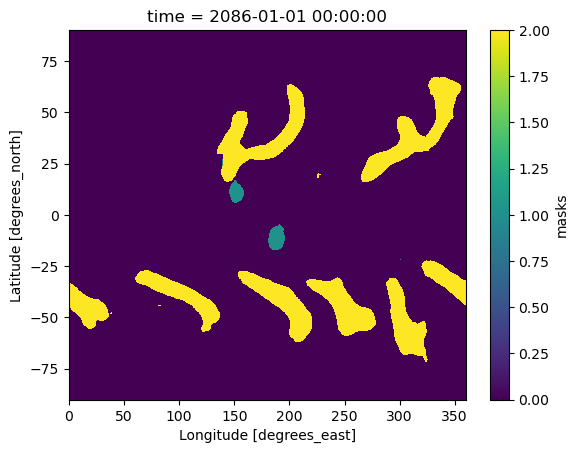

In [8]:
cnet_test_mask.isel(time=0).plot()

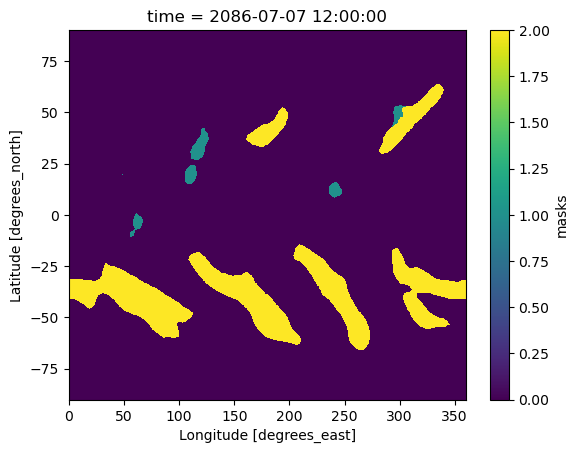

In [11]:
cnet_test_mask.isel(time=1500).plot();

### Read in files

In [25]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks/" for y in rcp85_yrs]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_v2/" for y in rcp85_yrs] # updated data processing (raw U850/V850)
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std in config file
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85_yrs] # RCP8.5 data used to calculate means/std in config file (unweighted)

#cnet_files = "class_masks*.nc"

#### Slower way to read in

In [7]:
%%time
# read in all the masks
# adjust chunks for length of timeseries data
cnet = [xr.open_mfdataset(cesm_cnet_filepath+rcp85_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':100}, parallel=True) for i,f in enumerate(cnet_folders)]

# concat across time
cnet_concat = xr.concat(cnet,dim='time')

CPU times: user 2.12 s, sys: 405 ms, total: 2.52 s
Wall time: 21.5 s


In [8]:
cnet_concat

<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 43800)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(100, 768, 1152), meta=np.ndarray>

In [9]:
cnet_mask = cnet_concat.masks
cnet_mask

<xarray.DataArray 'masks' (time: 43800, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(43800, 768, 1152), dtype=int64, chunksize=(100, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Mon Feb 20 14:02:32 2023: cdo splitsel,1 2086...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

#### Faster way to read in

In [26]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file for i,f in enumerate(rcp85_folders)]
rcp85_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2086/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2087/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2088/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2089/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2090/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2091/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2092/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2093/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2094/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2095/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2096/masks_rcp85config/class_masks.nc',
 '/glade/c

In [27]:
%%time
# read in all the masks feeding the list of paths - faster!
cnet = xr.open_mfdataset(rcp85_paths, concat_dim='time', combine='nested', chunks={'time':50}, parallel=True)
cnet

CPU times: user 446 ms, sys: 24.1 ms, total: 470 ms
Wall time: 782 ms


<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 43800)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [28]:
cnet_mask = cnet.masks

### Static plot for visualization

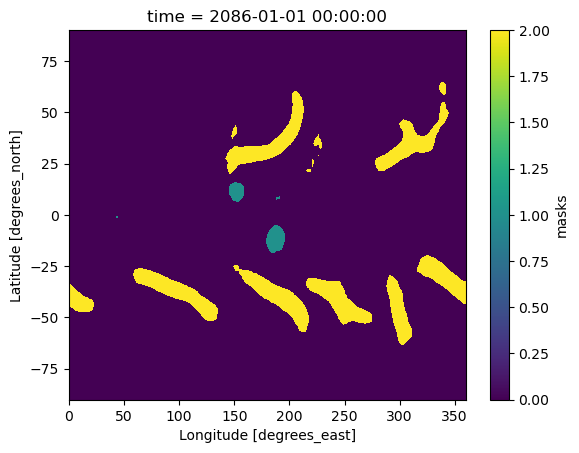

In [29]:
cnet_mask.isel(time=0).plot();

### Check for time indices with zero detection

In [30]:
cnet_mask_sum = cnet_mask.sum(dim=('lat','lon'))

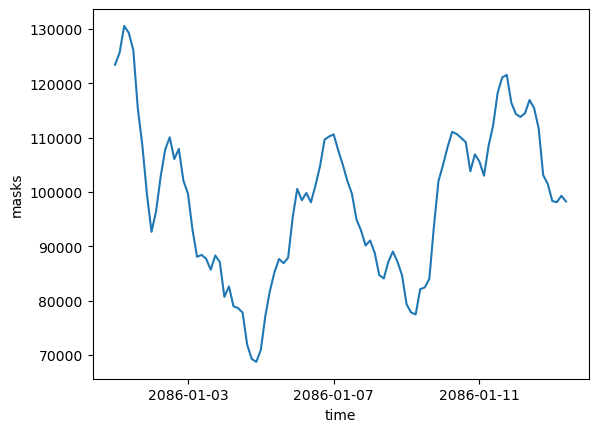

In [31]:
cnet_mask_sum.isel(time=slice(0,100)).plot()

In [32]:
cnet_mask_sum.where(cnet_mask_sum == 0).count().values

array(0)

RCP8.5 doesn't have any "empty" time indices

### Debugging zero detection time points
How many zero detection time points are there?

In [13]:
%%time
cnet_mask_sum.where(cnet_mask_sum == 0).count().values

array(1098)

This is ~2.5% of all time points for RCP8.5

In [14]:
1098/43800

0.02506849315068493

#### What are the indices?

In [15]:
cnet_mask_sum.where(cnet_mask_sum == 0).isel(time=slice(0,100)).values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

#### Print/visualize the zero time indices
They seem to be random but good to check

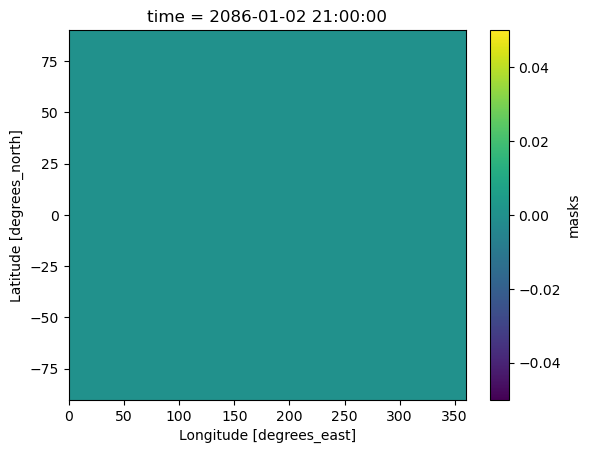

In [16]:
cnet_mask.isel(time=15).plot();

In [17]:
cnet_mask.isel(time=15, lat=10, lon=10).values

array(0)

In [18]:
cnet_mask_sum.where(cnet_mask_sum == 0)

<xarray.DataArray 'masks' (time: 43800)>
dask.array<where, shape=(43800,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00

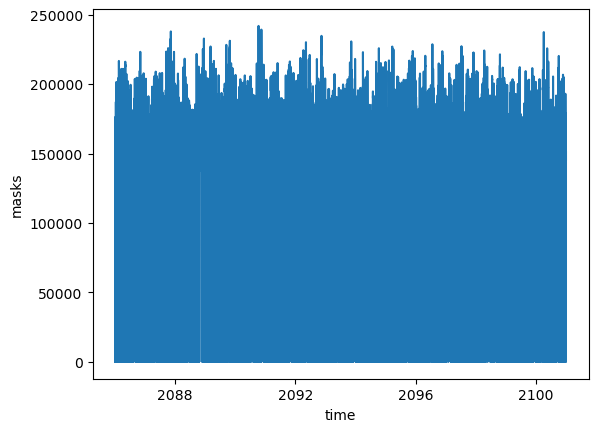

In [57]:
cnet_mask_sum.plot()

In [20]:
%%time
cnet_mask_sum.where(cnet_mask_sum == 0, drop=True)

CPU times: user 23.3 s, sys: 780 ms, total: 24 s
Wall time: 1min 56s


<xarray.DataArray 'masks' (time: 1098)>
dask.array<where, shape=(1098,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-02 21:00:00 ... 2100-12-31 15:00:00

In [22]:
%%time
print(cnet_mask_sum.where(cnet_mask_sum == 0, drop=True).time.values)

[cftime.DatetimeNoLeap(2086, 1, 2, 21, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2086, 1, 3, 6, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2086, 1, 4, 12, 0, 0, 0, has_year_zero=True) ...
 cftime.DatetimeNoLeap(2100, 12, 22, 18, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2100, 12, 23, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2100, 12, 31, 15, 0, 0, 0, has_year_zero=True)]
CPU times: user 26.3 s, sys: 920 ms, total: 27.3 s
Wall time: 2min 5s


CPU times: user 21.8 s, sys: 755 ms, total: 22.5 s
Wall time: 1min 40s


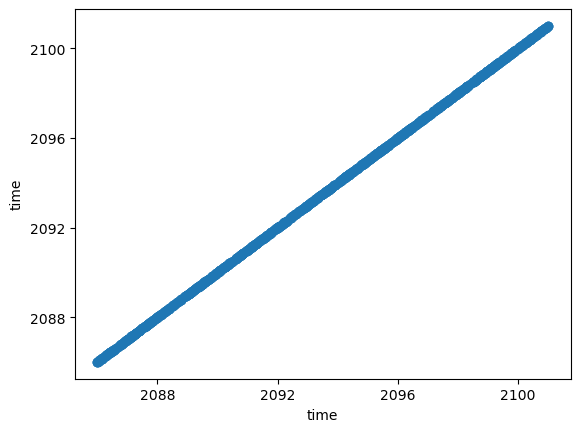

In [24]:
%%time
cnet_mask_sum.where(cnet_mask_sum == 0, drop=True).time.plot(marker="o")

### Trying again with pre-trained model using means/std updated for RCP8.5 data
Only ran for 2086-2089 to test

In [22]:
rcp85test_yrs = [str(i) for i in range(2086,2090)]
cnet_test_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85test_yrs]

cnet_files = "class_masks*.nc"

In [23]:
cnet_test_folders

['BRCP85C5CN/2086/masks_rcp85config/',
 'BRCP85C5CN/2087/masks_rcp85config/',
 'BRCP85C5CN/2088/masks_rcp85config/',
 'BRCP85C5CN/2089/masks_rcp85config/']

In [24]:
%%time
cnet_test = [xr.open_mfdataset(cesm_cnet_filepath+cnet_test_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cnet_test_folders)]

# concat across time
cnet_test_concat = xr.concat(cnet_test,dim='time')

CPU times: user 133 ms, sys: 4.24 ms, total: 137 ms
Wall time: 445 ms


In [25]:
cnet_test_concat

<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 11680)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2089-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [26]:
cnet_test_mask = cnet_test_concat.masks
cnet_test_mask

<xarray.DataArray 'masks' (time: 11680, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(11680, 768, 1152), dtype=int64, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2089-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Mon Feb 20 14:02:32 2023: cdo splitsel,1 2086...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [27]:
cnet_test_mask_sum = cnet_test_mask.sum(dim=('lat','lon'))

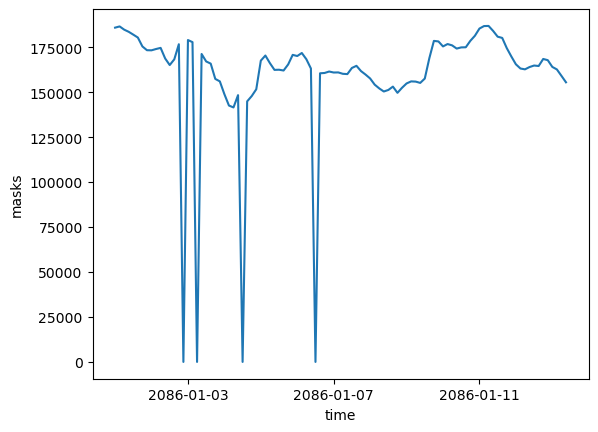

In [28]:
cnet_test_mask_sum.isel(time=slice(0,100)).plot()

In [30]:
cnet_test_mask_sum.where(cnet_test_mask_sum == 0).isel(time=slice(0,100)).values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

#### The indices are the same, despite changing the normalization values
Detection does look to vary slightly with different values, but the zero detection points are consistent

### Debugging the first problematic index - CESM variables

In [6]:
datacheck = xr.open_dataset(cesm_cnet_filepath+'BRCP85C5CN/2086/2086_all_vars_split000016.nc')
datacheck

<xarray.Dataset>
Dimensions:    (time: 1, bnds: 2, slat: 767, lat: 768, lon: 1152)
Coordinates:
  * time       (time) object 2086-01-02 21:00:00
  * slat       (slat) float64 -89.88 -89.65 -89.41 -89.18 ... 89.41 89.65 89.88
  * lat        (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon        (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Dimensions without coordinates: bnds
Data variables: (12/20)
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    w_stag     (slat) float64 ...
    gw         (lat) float64 ...
    V850       (time, lat, lon) float32 ...
    ...         ...
    f12vmr     (time) float64 ...
    n2ovmr     (time) float64 ...
    ndcur      (time) int32 ...
    nscur      (time) int32 ...
    nsteph     (time) int32 ...
    sol_tsi    (time) float64 ...
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Mon Feb 20 14:02:32 2023: cdo splitsel,1 2086...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [36]:
datacheck.PSL

<xarray.DataArray 'PSL' (time: 1, lat: 768, lon: 1152)>
[884736 values with dtype=float32]
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:  Sea level pressure
    units:      Pa

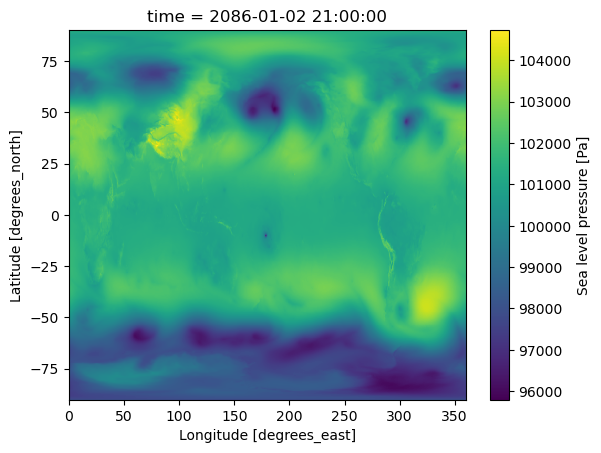

In [50]:
datacheck.PSL.isel(time=0).plot()

In [26]:
datacheck.PSL.isnull().sum().values

array(0)

In [34]:
datacheck.TMQ

<xarray.DataArray 'TMQ' (time: 1, lat: 768, lon: 1152)>
[884736 values with dtype=float32]
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2022-12-20

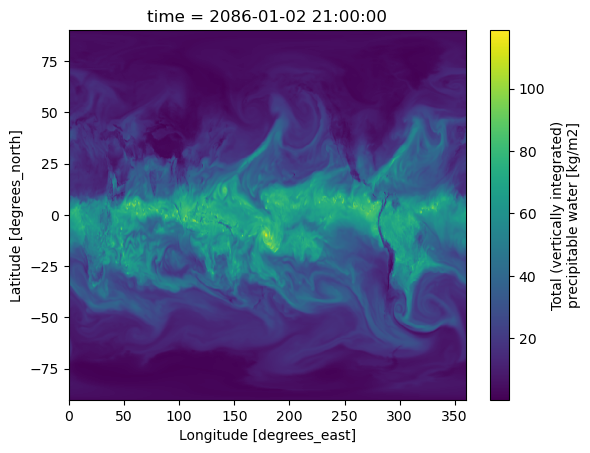

In [52]:
datacheck.TMQ.isel(time=0).plot()

In [25]:
datacheck.TMQ.isnull().sum().values

array(0)

In [7]:
datacheck.U850

<xarray.DataArray 'U850' (time: 1, lat: 768, lon: 1152)>
[884736 values with dtype=float32]
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:      Zonal wind at 850 mbar pressure surface
    units:          m/s
    mdims:          1
    cell_methods:   time: mean
    title:          3-hr averaged Zonal wind at 850 mbar pressure surface
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at ML-extremes/notebooks/Data_Processing...
    conventions:    CF 1.0
    creation_date:  2023-02-17

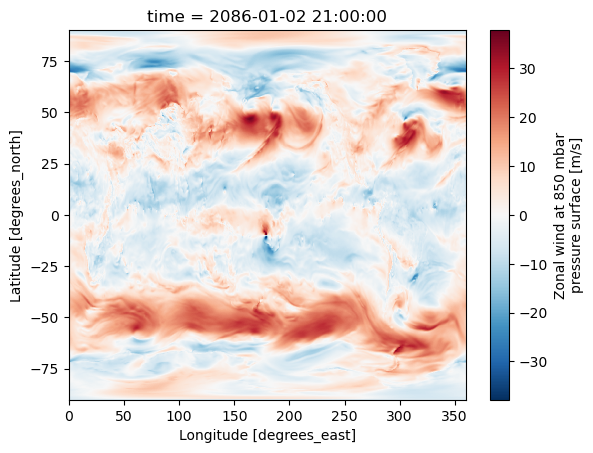

In [8]:
datacheck.U850.isel(time=0).plot()

In [23]:
datacheck.U850.isnull().sum().values

array(2)

In [32]:
datacheck.U850.where(datacheck.U850.isnull()==True, drop=True)

<xarray.DataArray 'U850' (time: 1, lat: 2, lon: 1)>
array([[[nan],
        [nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 34.85 35.08
  * lon      (lon) float64 63.44
Attributes:
    long_name:      Zonal wind at 850 mbar pressure surface
    units:          m/s
    mdims:          1
    cell_methods:   time: mean
    title:          3-hr averaged Zonal wind at 850 mbar pressure surface
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at ML-extremes/notebooks/Data_Processing...
    conventions:    CF 1.0
    creation_date:  2023-02-17

In [35]:
datacheck.V850

<xarray.DataArray 'V850' (time: 1, lat: 768, lon: 1152)>
[884736 values with dtype=float32]
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:      Meridional wind at 850 mbar pressure surface
    units:          m/s
    mdims:          1
    cell_methods:   time: mean
    title:          3-hr averaged Meridional wind at 850 mbar pressure surface
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at ML-extremes/notebooks/Data_Processing...
    conventions:    CF 1.0
    creation_date:  2023-02-18

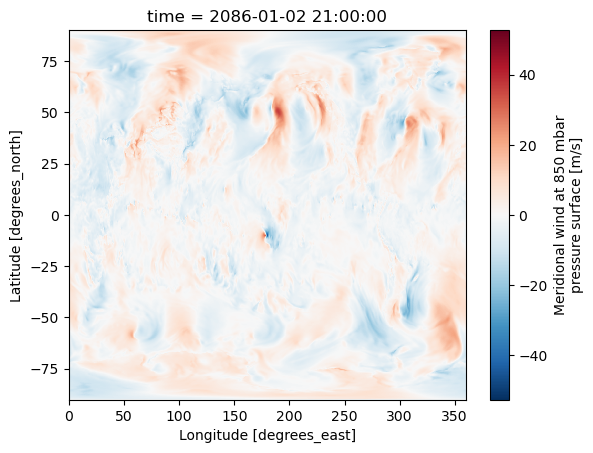

In [39]:
datacheck.V850.isel(time=0).plot()

In [35]:
datacheck.V850.isnull().sum().values

array(2)

In [33]:
datacheck.V850.where(datacheck.V850.isnull()==True, drop=True)

<xarray.DataArray 'V850' (time: 1, lat: 2, lon: 1)>
array([[[nan],
        [nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 34.85 35.08
  * lon      (lon) float64 63.44
Attributes:
    long_name:      Meridional wind at 850 mbar pressure surface
    units:          m/s
    mdims:          1
    cell_methods:   time: mean
    title:          3-hr averaged Meridional wind at 850 mbar pressure surface
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at ML-extremes/notebooks/Data_Processing...
    conventions:    CF 1.0
    creation_date:  2023-02-18

### SOLVED: Why is cgnet producing zero masks for certain time points?
Problem with missing values in U850 and V850 input fields.\
Update data processing to use raw U850/V850 output instead of interpolated.

## Global AR frequency maps

In [33]:
npercentARs = 100*((cnet_mask.clip(min=1)-1).sum(dim='time'))/len(cnet_mask.time)
#npercentARs.plot(robust=True);

In [34]:
npercentARs = npercentARs.persist()

In [35]:
npercentARs.max().values

array(44.75799087)

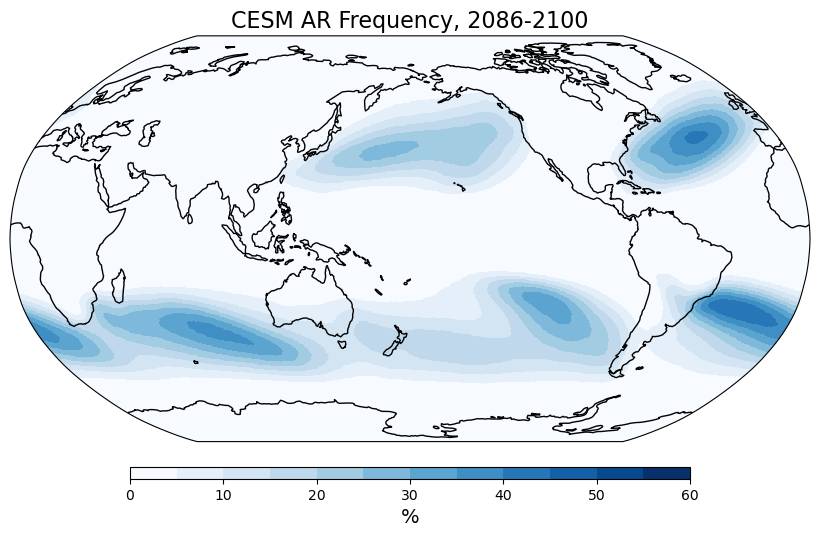

In [36]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)
vmax=60 # use the same value for hist/rcp2.6 to compare

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs.lat
lon = npercentARs.lon
pc = ax.pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, 2086-2100', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_CESM_rcp85.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_rcp85_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_rcp85_config.png', bbox_inches='tight')

### Global TC frequency masks
Note: release the ``npercentARs`` variable from memory so the ``npercentTCs`` processing doesn't run out of memory (or increase the dask request)

In [37]:
del npercentARs

In [38]:
# can't figure out how to use .clip to select TCs
npercentTCs = 100*(cnet_mask.where(cnet_mask==1).sum(dim='time'))/len(cnet_mask.time)

In [39]:
npercentTCs = npercentTCs.persist()

In [40]:
npercentTCs.max().values

array(12.04794521)

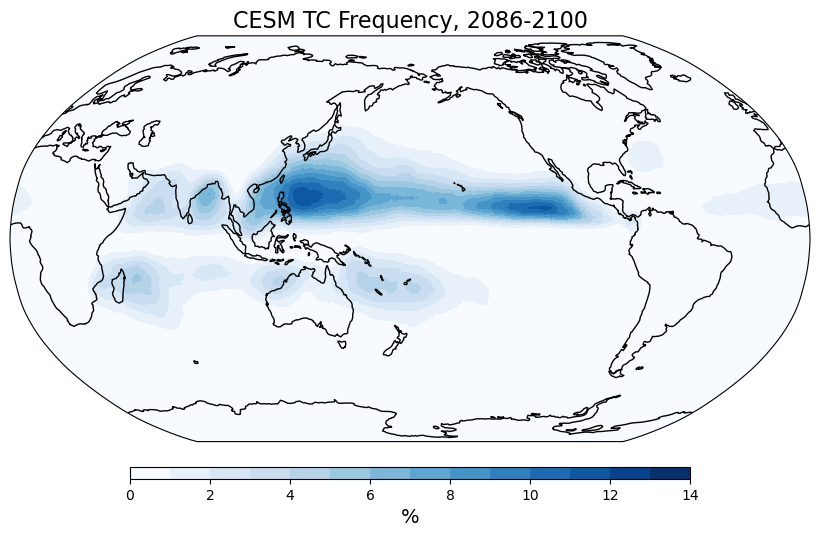

In [41]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 14)
vmax=14 # use the same value for hist/rcp2.6 to compare

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentTCs.lat
lon = npercentTCs.lon
pc = ax.pcolormesh(lon, lat, npercentTCs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM TC Frequency, 2086-2100', fontsize=16);

#plt.savefig('../figures/toSCP/npercentTCs_CESM_rcp85.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_rcp85_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_rcp85_config.png', bbox_inches='tight')

In [24]:
del npercentTCs

## TO DO: spot check detected events with underlying CESM fields for each simulation/time period
Are the ARs and TCs in the right place(s)?\
How would we check this systematically? One way could be to composite the underlying fields (e.g., TMQ) across the times where there is an AR detected.\
Could also use the information from the underlying fields to determine an event "center" e.g., for TCs.

### Close cluster/client as needed

In [26]:
client.close()
cluster.close()